In [2]:
import torch
print(torch.__version__)

2.4.0+cpu


## Обучение нейросети

In [3]:
# Обычно нейросеть состоит из множества слоёв.

# Чтобы каждый раз не было необходимости писать вручную преобразования внутри нейронной сети,
#  слои оборачиваются в специального вида классы, позволяющие упростить и ускорить работу с нейросетью.

# Ниже приведён пример того, как можно создать соответствующий класс для линейного слоя нейросети.

# torch.nn.Module - специальный класс в PyTorch. Лучше наследовать собственные классы слоёв
#  от него, чтобы избежать лишней работы по их реализации.
class MyLinear(torch.nn.Module):
    # При наследовании нужно переопределить 2 функции внутри класса:
    #  1. __init__. Эта функция отвечает за инициализацию слоя. В неё передаются параметры,
    #      необходимые для того, чтобы понять, сколько и каких весов будет у слоя,
    #      как их проинициализировать и т.д.
    def __init__(
        self,
        in_features,   # Число параметров на входе в слой.
        out_features,  # Число параметров на выходе из слоя.
    ):
        # Специальная функция для отнаследованных классов. Вызывается в начале __init__.
        super().__init__()
        # Параметры слоя задаём через nn.Parameter, чтобы PyTorch знал, что это обучаемые веса.
        self.weight = torch.nn.Parameter(torch.randn(in_features, out_features))  # Матрица весов.
        self.bias = torch.nn.Parameter(torch.zeros(out_features))                 # Вектор смещения.

    #  2. forward. Эта функция отвечает за прямой проход через слой нейросети
    #      (получает на вход данные, выдаёт преобразованные данные).
    def forward(self, input):
        return (input @ self.weight) + self.bias

In [4]:
# Многие слои уже присутствуют в PyTorch, и их классы находятся в torch.nn.
# К примеру — линейный слой.
linear_layer = torch.nn.Linear(2, 3)

x = torch.rand(2)

linear_layer(x)

tensor([0.5833, 1.0957, 0.1600], grad_fn=<ViewBackward0>)

In [5]:
# Перепишем шаг обучения с нововведениями.
n = 5  # Сколько переменных получаем на вход.
k = 2  # Сколько переменных предсказываем.

batch_size = 10  # Размер батча — по скольким примерам за раз считаем градиент.

# Данные и целевое значение для задачи классификации на k классов.
x = torch.rand(batch_size, n)         # Матрица размера (batch_size x n).
y_true = torch.randint(4, size=(k,))  # Вектор размера (k).

# Будем использовать двухслойную нейросеть:
#  x > Линейный слой 1 > Функция активации 1 > Линейный слой 2 > Softmax (т. к. задача классификации).
hidden_size = 5  # Размер скрытого слоя.
lin1 = torch.nn.Linear(n, hidden_size)
act1 = torch.nn.Tanh()
lin2 = torch.nn.Linear(hidden_size, k)
log_softmax = torch.nn.LogSoftmax(dim=1)  # dim указывает, вдоль какого измерения мы применяем Softmax.

# Полностью наше преобразование будет иметь следующий вид:
y_pred = log_softmax(lin2(act1(lin1(x))))

# Можно записать его поэтапно (например, внутри forward-функции слоя):
h = act1(lin1(x))              # Матрица размера (batch_size x hidden_size).
y_pred = log_softmax(lin2(h))  # Матрица размера (batch_size x k).

# Но так не удобно писать каждый раз, когда мы хотим применить модель.
# Поэтому есть специальная обёртка torch.nn.Sequential(), позволяющая превратить
#  серию слоёв в один слой, применяющий все слои один за другим.
model = torch.nn.Sequential(
    lin1,
    act1,
    lin2,
    log_softmax,
)

model(x)

tensor([[-0.3738, -1.1651],
        [-0.5289, -0.8898],
        [-0.5854, -0.8139],
        [-0.5171, -0.9069],
        [-0.5660, -0.8389],
        [-0.4510, -1.0134],
        [-0.3645, -1.1858],
        [-0.4889, -0.9501],
        [-0.6355, -0.7543],
        [-0.4107, -1.0881]], grad_fn=<LogSoftmaxBackward0>)

In [6]:
model

Sequential(
  (0): Linear(in_features=5, out_features=5, bias=True)
  (1): Tanh()
  (2): Linear(in_features=5, out_features=2, bias=True)
  (3): LogSoftmax(dim=1)
)

In [7]:
# Можно задавать Sequential так,
#  чтобы подписи в описании модели были более понятными.
from collections import OrderedDict

model = torch.nn.Sequential(
    OrderedDict([
        ("linear_1", torch.nn.Linear(n, hidden_size)),
        ("activation_1", torch.nn.Tanh()),
        ("linear_2", torch.nn.Linear(hidden_size, k)),
        ("log_softmax", torch.nn.LogSoftmax(dim=1)),
    ])
)

model

Sequential(
  (linear_1): Linear(in_features=5, out_features=5, bias=True)
  (activation_1): Tanh()
  (linear_2): Linear(in_features=5, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)

In [27]:
# Попробуем на конкретных данных.
from sklearn.datasets import make_classification

# Создадим датасет для классификации.
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_classes=2,
    
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

X.shape, y.shape  # 1000 примеров, 2 признака, проводим класификацию на 2 класса.

(torch.Size([1000, 2]), torch.Size([1000]))

In [28]:
# 2 класса.
y.min(), y.max()

(tensor(0), tensor(1))

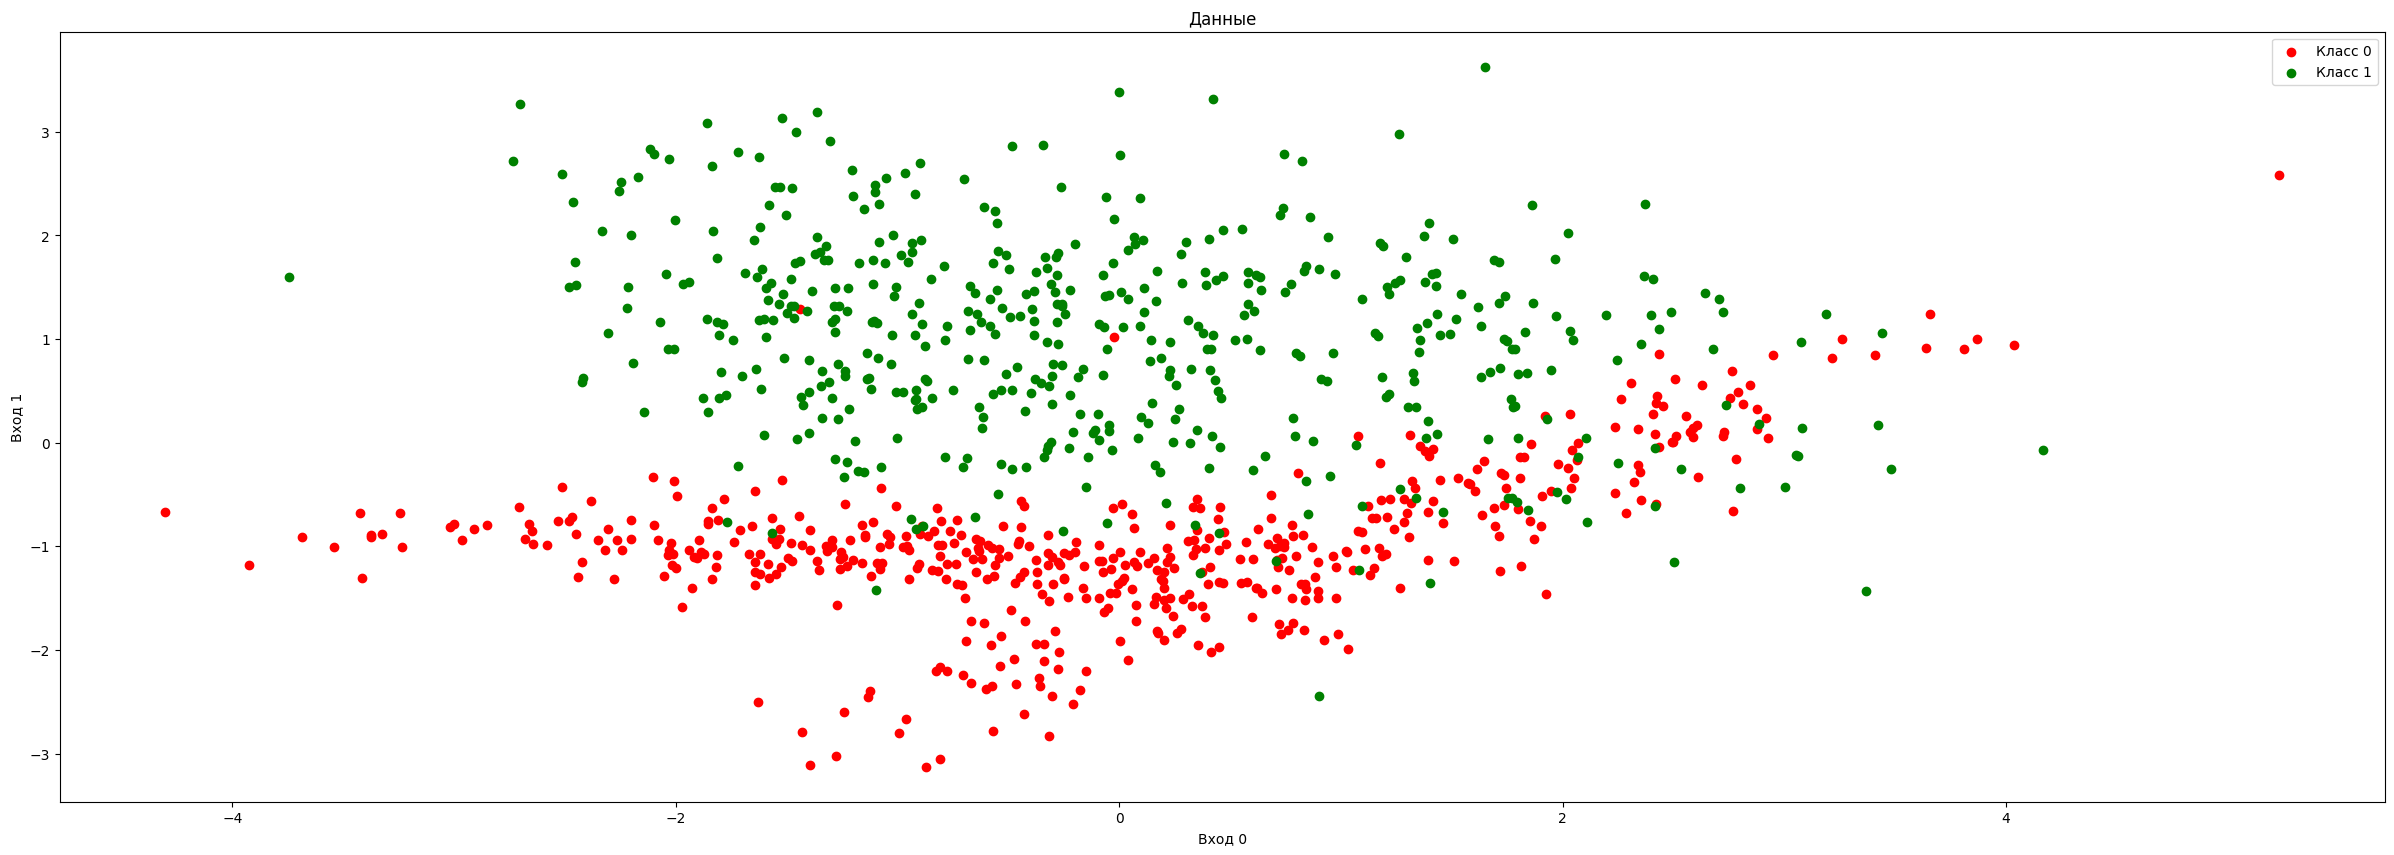

In [29]:
# Визуализируем данные.
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

fig, ax = plt.subplots(figsize=(30, 10))
colors = ["red", "green"]
for target in range(2):
    plt.scatter(X[y == target, 0], X[y == target, 1], label=f"Класс {target}", c=colors[target])

plt.title("Данные")
plt.xlabel("Вход 0")
plt.ylabel("Вход 1")
plt.legend()
plt.show()

In [30]:
# Делаем сетку точек на плоскости, чтобы потом проверять предсказания нашей модели.
xy_min, xy_max = -4, 4
grid_size = 120
grid = torch.linspace(xy_min, xy_max, grid_size, dtype=torch.float32)
grid_x_1, grid_x_2 = torch.meshgrid(grid, grid, indexing='ij')

grid = torch.stack([grid_x_1.reshape(-1), grid_x_2.reshape(-1)], dim=1)
print(grid.shape, grid.dtype)

torch.Size([14400, 2]) torch.float32


In [31]:
# Обучим простую двухслойную нейросеть на задачу классификации.
model = torch.nn.Sequential(
    OrderedDict([
        ("linear_1", torch.nn.Linear(2, 4)),
        ("activation_1", torch.nn.ReLU()),
        ("linear_2", torch.nn.Linear(4, 2)),
        ("log_softmax", torch.nn.LogSoftmax(dim=1)),
    ])
)

model

Sequential(
  (linear_1): Linear(in_features=2, out_features=4, bias=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=4, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)

In [44]:
# Оптимайзеры.
optimizer = torch.optim.SGD(
    model.parameters(),  # Передаём все тензоры, участвующие в градиентном спуске.
    lr=1.,               # learning rate — величина шага градиентного спуска.
)

# Две основные функции для оптимайзера:
#  1. optimizer.step. Сделать шаг оптимизации, т. е. в случае простого SGD
#     применить w -= lr * w.grad для всех тензоров, участвующих в обучении.
#  2. optimizer.zero_grad. Обнулить все градиенты, т. е. применить w.grad.zero_()
#     для всех тензоров, участвующих в обучении.

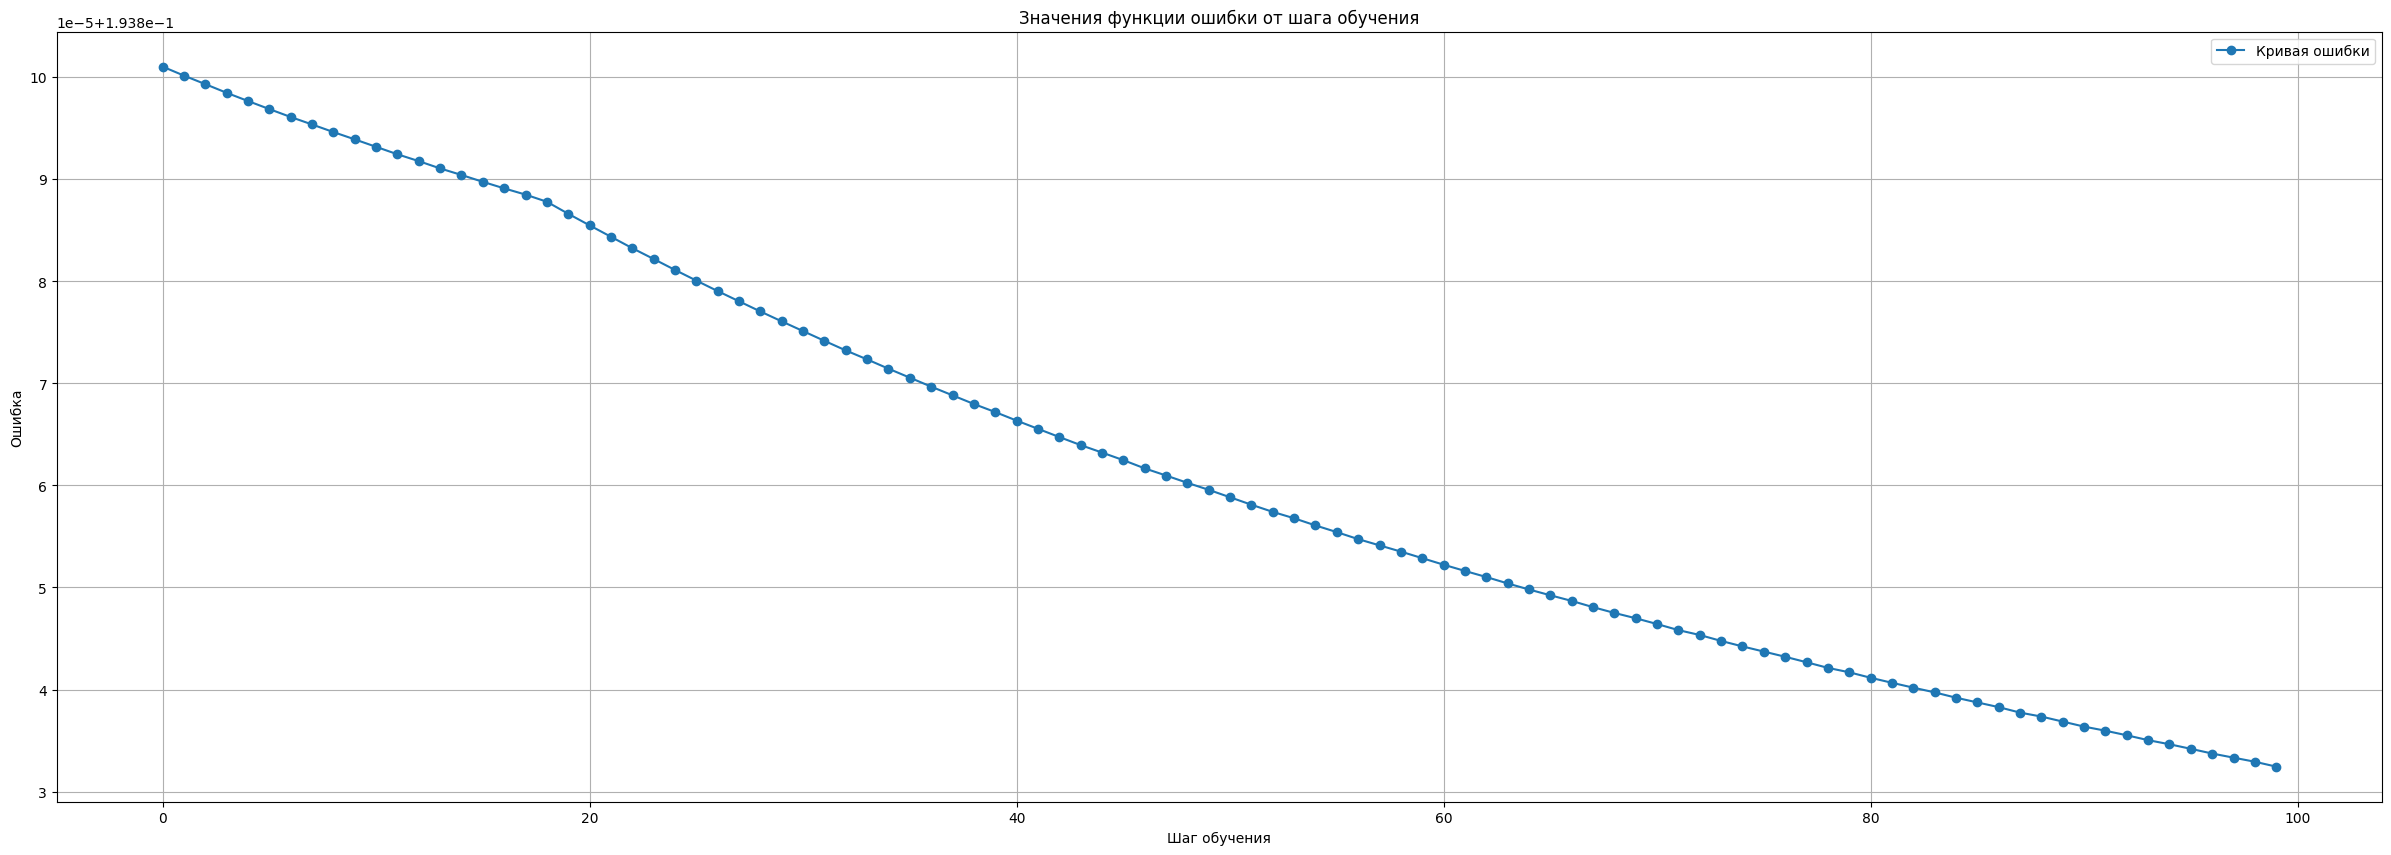

In [45]:
losses = []      # Для визуализации будем собирать информацию об ошибке по ходу обучения.
grid_preds = []  # Также будем собирать информацию о предсказаниях модели.

# Используем NLLLoss, т. к. задача классификации
#  и мы предсказываем лог-вероятности классов.
loss_fn = torch.nn.NLLLoss()

for step in range(1, 101):
    optimizer.zero_grad()      # Обнуляем градиенты.
    y_pred = model(X)          # Считаем прямой проход на всех данных.
    loss = loss_fn(y_pred, y)  # Считаем величину ошибки.
    
    # Записываем значение ошибки в список, чтобы позже визуализировать
    #  (.item() возвращает само значение внутри тензора из одного значения).
    losses.append(loss.item())
    
    loss.backward()   # Считаем градиенты для всех задействованных тензоров.
    optimizer.step()  # Делаем шаг градиентного спуска.
    
    with torch.no_grad():  # Используем обёртку, т. к. нам не требуются градиенты на наших тестовых предсказаниях.
        grid_preds.append(model(grid))
    

# Визуализируем, как менялось значение ошибки на данных.
fig, ax = plt.subplots(figsize=(30, 10))
plt.plot(losses, "o-", label="Кривая ошибки")

plt.title("Значения функции ошибки от шага обучения")
plt.xlabel("Шаг обучения")
plt.ylabel("Ошибка")
plt.grid()
plt.legend()
plt.show()

In [46]:
# Посмотрим, как выглядят предсказания нашей модели на последнем шаге.
pred_class_probs = grid_preds[-1].exp()  # Получаем вероятности классов на последнем шаге обучения для каждой точки сетки.
print(f"Предсказанные вероятности классов:\n{pred_class_probs}\n")

pred_class = 1 * (pred_class_probs[:, 1] > 0.5)  # Предсказанные классы умножаем на 1, чтобы получить int вместо bool.
print(f"Предсказанные классы:\n{pred_class}")

Предсказанные вероятности классов:
tensor([[1.0000e+00, 2.8420e-12],
        [1.0000e+00, 3.5819e-12],
        [1.0000e+00, 4.5144e-12],
        ...,
        [3.7477e-04, 9.9963e-01],
        [2.9622e-04, 9.9970e-01],
        [2.3413e-04, 9.9977e-01]])

Предсказанные классы:
tensor([0, 0, 0,  ..., 1, 1, 1])


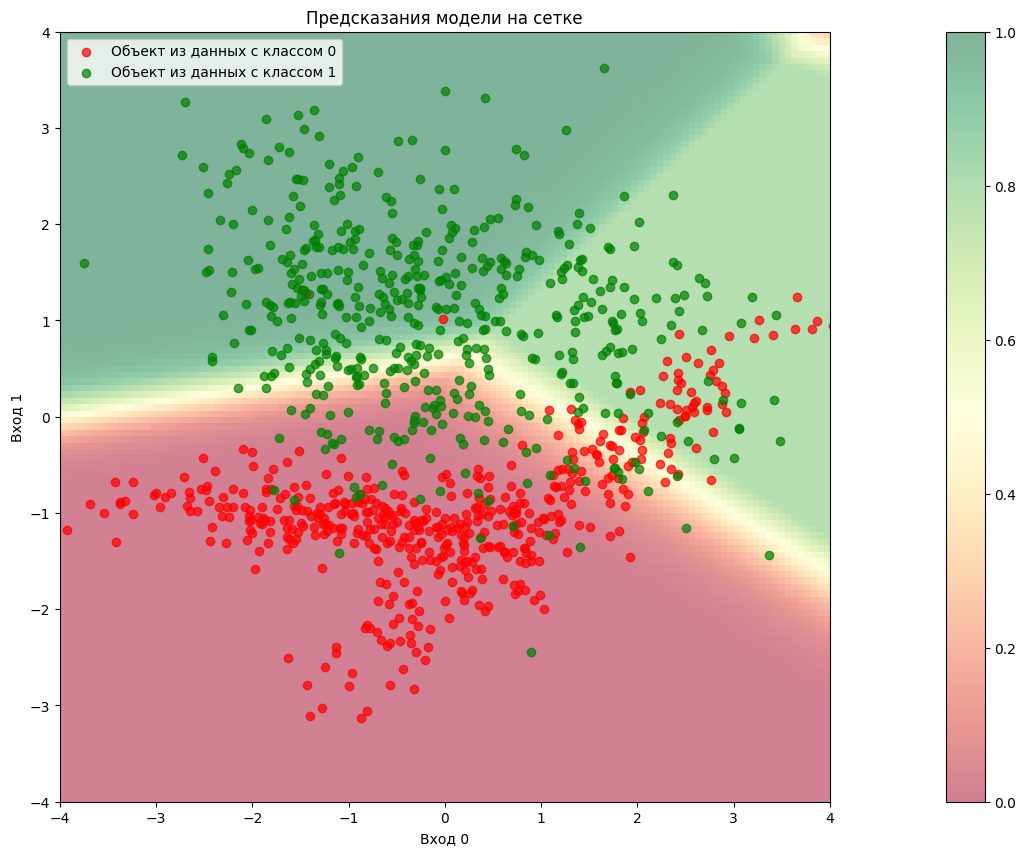

In [47]:
# Отрисовываем.
fig, ax = plt.subplots(figsize=(30, 10))
colors = ["red", "green"]
for target in range(2):
    plt.scatter(
        X[y == target, 0],
        X[y == target, 1],
        marker="o",
        label=f"Объект из данных с классом {target}",
        c=colors[target],
        alpha=0.7,
    )
    
plt.imshow(
    pred_class_probs[:, 0].reshape(grid_size, grid_size).T,
    vmin=0.,
    vmax=1.,
    cmap=mpl.colormaps["RdYlGn"],
    extent=(xy_min, xy_max, xy_min, xy_max),
    alpha=0.5,
)

plt.title("Предсказания модели на сетке")
plt.xlabel("Вход 0")
plt.ylabel("Вход 1")
plt.legend()
plt.colorbar()
plt.show()

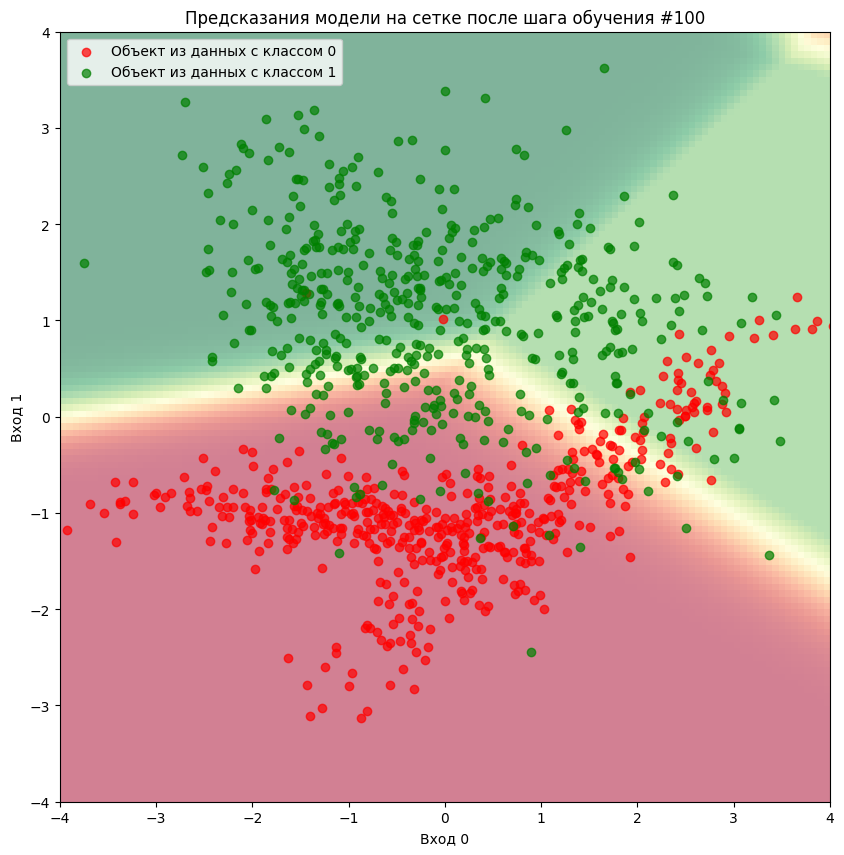

In [48]:
# Анимация того, как обучалась модель.
from time import sleep
from IPython.display import clear_output

draw_x0s = []
draw_x1s = []
draw_y0s = []
draw_y1s = []
all_pred_class_probs = []

# Предпосчитываем анимации для скорости.
for i in range(100):
    pred_class_probs = grid_preds[i].exp()
    
    draw_x0s.append(X[y == 0, 0])
    draw_x1s.append(X[y == 1, 0])
    
    draw_y0s.append(X[y == 0, 1])
    draw_y1s.append(X[y == 1, 1])
    
    all_pred_class_probs.append(pred_class_probs[:, 0].reshape(grid_size, grid_size).T)

# Отрисовываем.
for i in range(100):
    clear_output(True)
    
    fig, ax = plt.subplots(figsize=(30, 10))
    for xs, ys, meta in [
        (draw_x0s, draw_y0s, ("o", f"Объект из данных с классом 0", "red")),
        (draw_x1s, draw_y1s, ("o", f"Объект из данных с классом 1", "green")),
    ]:
        plt.scatter(
            xs[i],
            ys[i],
            marker=meta[0],
            label=meta[1],
            c=meta[2],
            alpha=0.7,
        )
        
    plt.imshow(
    all_pred_class_probs[i],
        vmin=0.,
        vmax=1.,
        cmap=mpl.colormaps["RdYlGn"],
        extent=(xy_min, xy_max, xy_min, xy_max),
        alpha=0.5,
    )

    plt.title(f"Предсказания модели на сетке после шага обучения #{i+1}")
    plt.xlabel("Вход 0")
    plt.ylabel("Вход 1")
    plt.legend()
    plt.show()
    
#     sleep(0.2)